In this notebook, we extract shapley values and visualize them

In [1]:
# read the file names and split into train test with size 50%
from read_data import read_save
read_save()

from read_data import tr_test_split
train_data_files, test_data_files = tr_test_split(0.5)

In [2]:
# generate features from the data (node features and connectivity)
from read_data import build_data
from read_data import stack_arrays
from process import label2skip, uniform, standardize_data, get_lap

train_X, train_graphs, train_y = build_data(train_data_files, size=500, cal_conn="corr", bands=True)
test_X, test_graphs, test_y = build_data(test_data_files, size=500, cal_conn="corr", bands=True)
train_X_orig, train_graphs_orig, train_y_orig = stack_arrays(train_X, train_graphs, train_y)
test_X_orig, test_graphs_orig, test_y_orig = stack_arrays(test_X, test_graphs, test_y)

train_graphs, train_X, train_y =  label2skip(train_graphs_orig, train_X_orig, train_y_orig, skip_label=1)
test_graphs, test_X, test_y =  label2skip(test_graphs_orig, test_X_orig, test_y_orig, skip_label=1)
train_graphs, test_graphs = uniform(train_graphs, test_graphs)
train_X, test_X = standardize_data(train_X, test_X)
train_graphs = get_lap(train_graphs)
test_graphs = get_lap(test_graphs)

100%|███████████████████████████████████████████████████████████████████████████| 2911/2911 [00:10<00:00, 286.12it/s]


In [289]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
import networkx as nx
import copy

class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features*k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.bmm(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                
                x2 = 2 * torch.bmm(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.view(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F

class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_hidden_layers=2, dropout=0, k=3):
        super(ChebNetGCN, self).__init__()

        self.dropout = nn.Dropout(p=0.5)

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        
    def forward(self, x: torch.Tensor, A: torch.sparse_coo_tensor):
        #print(x.shape)
        #x = self.conv(x)
        #print(x.shape)
        x = F.relu(self.input_conv(x, A))
        x= self.dropout(x)
        #print(A.shape, x.shape)
        for conv in self.hidden_convs:
            #x = x.transpose(2, 1)
            x = F.relu(conv(x, A))
            x = self.dropout(x)
            
        #x = x.transpose(2, 1)
        x = self.output_conv(x, A)
        x = self.dropout(x)
        x = x.squeeze()
        return x


class CorrChebNetGCN(nn.Module):
    def __init__(self, in_features, num_classes, use_dropout=False):
        super(CorrChebNetGCN, self).__init__()
        
        self.use_dropout = use_dropout
        self.model_Delta = ChebNetGCN(in_features, 32, 19, 32, use_dropout)
        self.model_Theta = ChebNetGCN(in_features, 32, 19, 32, use_dropout)
        self.model_Alpha = ChebNetGCN(in_features, 32, 19, 32, use_dropout)
        self.model_Beta = ChebNetGCN(in_features, 32, 19, 32, use_dropout)
        self.model_Gamma = ChebNetGCN(in_features, 32, 19, 32, use_dropout)
        self.fc = nn.Linear(158, num_classes)
        self.BN1 = nn.BatchNorm1d(158)
        self.conv = nn.Conv1d(in_channels=19, out_channels=10, kernel_size=3)
        self.softmax = nn.Softmax(-1)
        
    def forward(self, x: torch.Tensor, A: torch.Tensor):               
        out1 = self.model_Delta(x[:, :, :, 0], A[:, 0])
        out2 = self.model_Theta(x[:, :, :, 1], A[:, 1])
        out3 = self.model_Alpha(x[:, :, :, 2], A[:, 2])
        out4 = self.model_Beta(x[:, :, :, 3], A[:, 3])
        out5 = self.model_Gamma(x[:, :, :, 4], A[:, 4])
        
        out = torch.cat((out1, out2, out3, out4, out5), dim=-1)
        out = self.conv(out)
        if self.use_dropout:
            out = nn.Dropout(p=0.5)(out)
        batch =None
        out = global_mean_pool(out, batch)
        out = self.BN1(out)
        out = self.fc(out)
        #here we do bilinear pooling
        return out

In [294]:
from tqdm import tqdm
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch

#from model import CorrChebNetGCN

NUM_CHANNELS = 19
NUM_CLASSES = 2
NUM_NODE_FEATURES = 11
BATCH_SIZE = 200
DEVICE = torch.device("cpu")

def trainer(num_epochs, model, train_iter):
    print("Training Model....")
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    for epoch in tqdm(range(1, num_epochs + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step() 
    return model

In [295]:
# build pytorch data loader and start training
from sklearn.preprocessing import OneHotEncoder
from process import data_loader
#from train import trainer
import torch

DEVICE = torch.device("cpu")
BATCH_SIZE = 200

encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.transform(test_y).toarray()

train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
dropout_model = CorrChebNetGCN(in_features=NUM_NODE_FEATURES, num_classes=NUM_CLASSES, use_dropout=True)
dropout_model = trainer(20, dropout_model, train_iter)

Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.41s/it]


In [296]:
# measure evaluation metrics
from evaluate import cal_accuracy

print("Train Accuracy")
train_acc = cal_accuracy(dropout_model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

print("Test Accuracy")
test_acc = cal_accuracy(dropout_model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Train Accuracy
Accuracy:  0.987446707721459
Precision:  [0.99630749 0.96621078]
Recall:  [0.98604651 0.99092409]
F1:  [0.99115044 0.97841141]
Confusion Matrix:  [[2968   42]
 [  11 1201]]
Test Accuracy
Accuracy:  0.9890072140158022
Precision:  [1.         0.96822244]
Recall:  [0.98347107 1.        ]
F1:  [0.99166667 0.98385469]
Confusion Matrix:  [[1904   32]
 [   0  975]]


In [297]:
# Ensemble Modeling
ensemble_size = 5
ensemble = [CorrChebNetGCN(in_features=NUM_NODE_FEATURES, 
                           num_classes=NUM_CLASSES, 
                           use_dropout=True) 
            for _ in range(ensemble_size)]


output_models = []
for model in ensemble:
    out_model = trainer(20, model, train_iter)
    output_models.append(out_model)
    train_acc = cal_accuracy(out_model, train_iter)
    print("Train Accuracy: ", train_acc[0])
    test_acc = cal_accuracy(out_model, test_iter)
    print("Test Accuracy: ", test_acc[0])

Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


Train Accuracy:  0.9784462340123165
Test Accuracy:  0.9910683613878393
Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


Train Accuracy:  0.9848413074372335
Test Accuracy:  0.9951906561319135
Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


Train Accuracy:  0.987446707721459
Test Accuracy:  0.9951906561319135
Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


Train Accuracy:  0.9848413074372335
Test Accuracy:  0.9958777052559258
Training Model....


100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


Train Accuracy:  0.9784462340123165
Test Accuracy:  0.9883201648917898


In [298]:
n_dropout_samples = 1000

# compute predictions, resampling dropout mask for each forward pass
test_X, test_graphs = torch.Tensor(test_X), torch.Tensor(test_graphs)
y_preds = [dropout_model(test_X, test_graphs).clone().detach().numpy() for _ in range(n_dropout_samples)]
y_preds = np.array(y_preds)

In [299]:
y_preds = torch.Tensor(y_preds)
test_y = torch.Tensor(test_y)
test_y_ohe = torch.Tensor(test_y_ohe)

In [300]:
import pandas as pd
def ece(y_test, preds, strategy = 'uniform'):
    df = pd.DataFrame({'target': y_test, 'proba': preds, 'bin': np.nan})
    
    if(strategy == 'uniform'):
        lim_inf = np.linspace(0, 0.9, 10)
        for idx, lim in enumerate(lim_inf):
            df.loc[df['proba'] >= lim, 'bin'] = idx

    elif(strategy == 'quantile'):
        pass
    
    df_bin_groups = pd.concat([df.groupby('bin').mean(), df['bin'].value_counts()], axis = 1)
    df_bin_groups['ece'] = (df_bin_groups['target'] - df_bin_groups['proba']).abs() * (df_bin_groups['bin'] / df.shape[0])
    return df_bin_groups['ece'].sum()

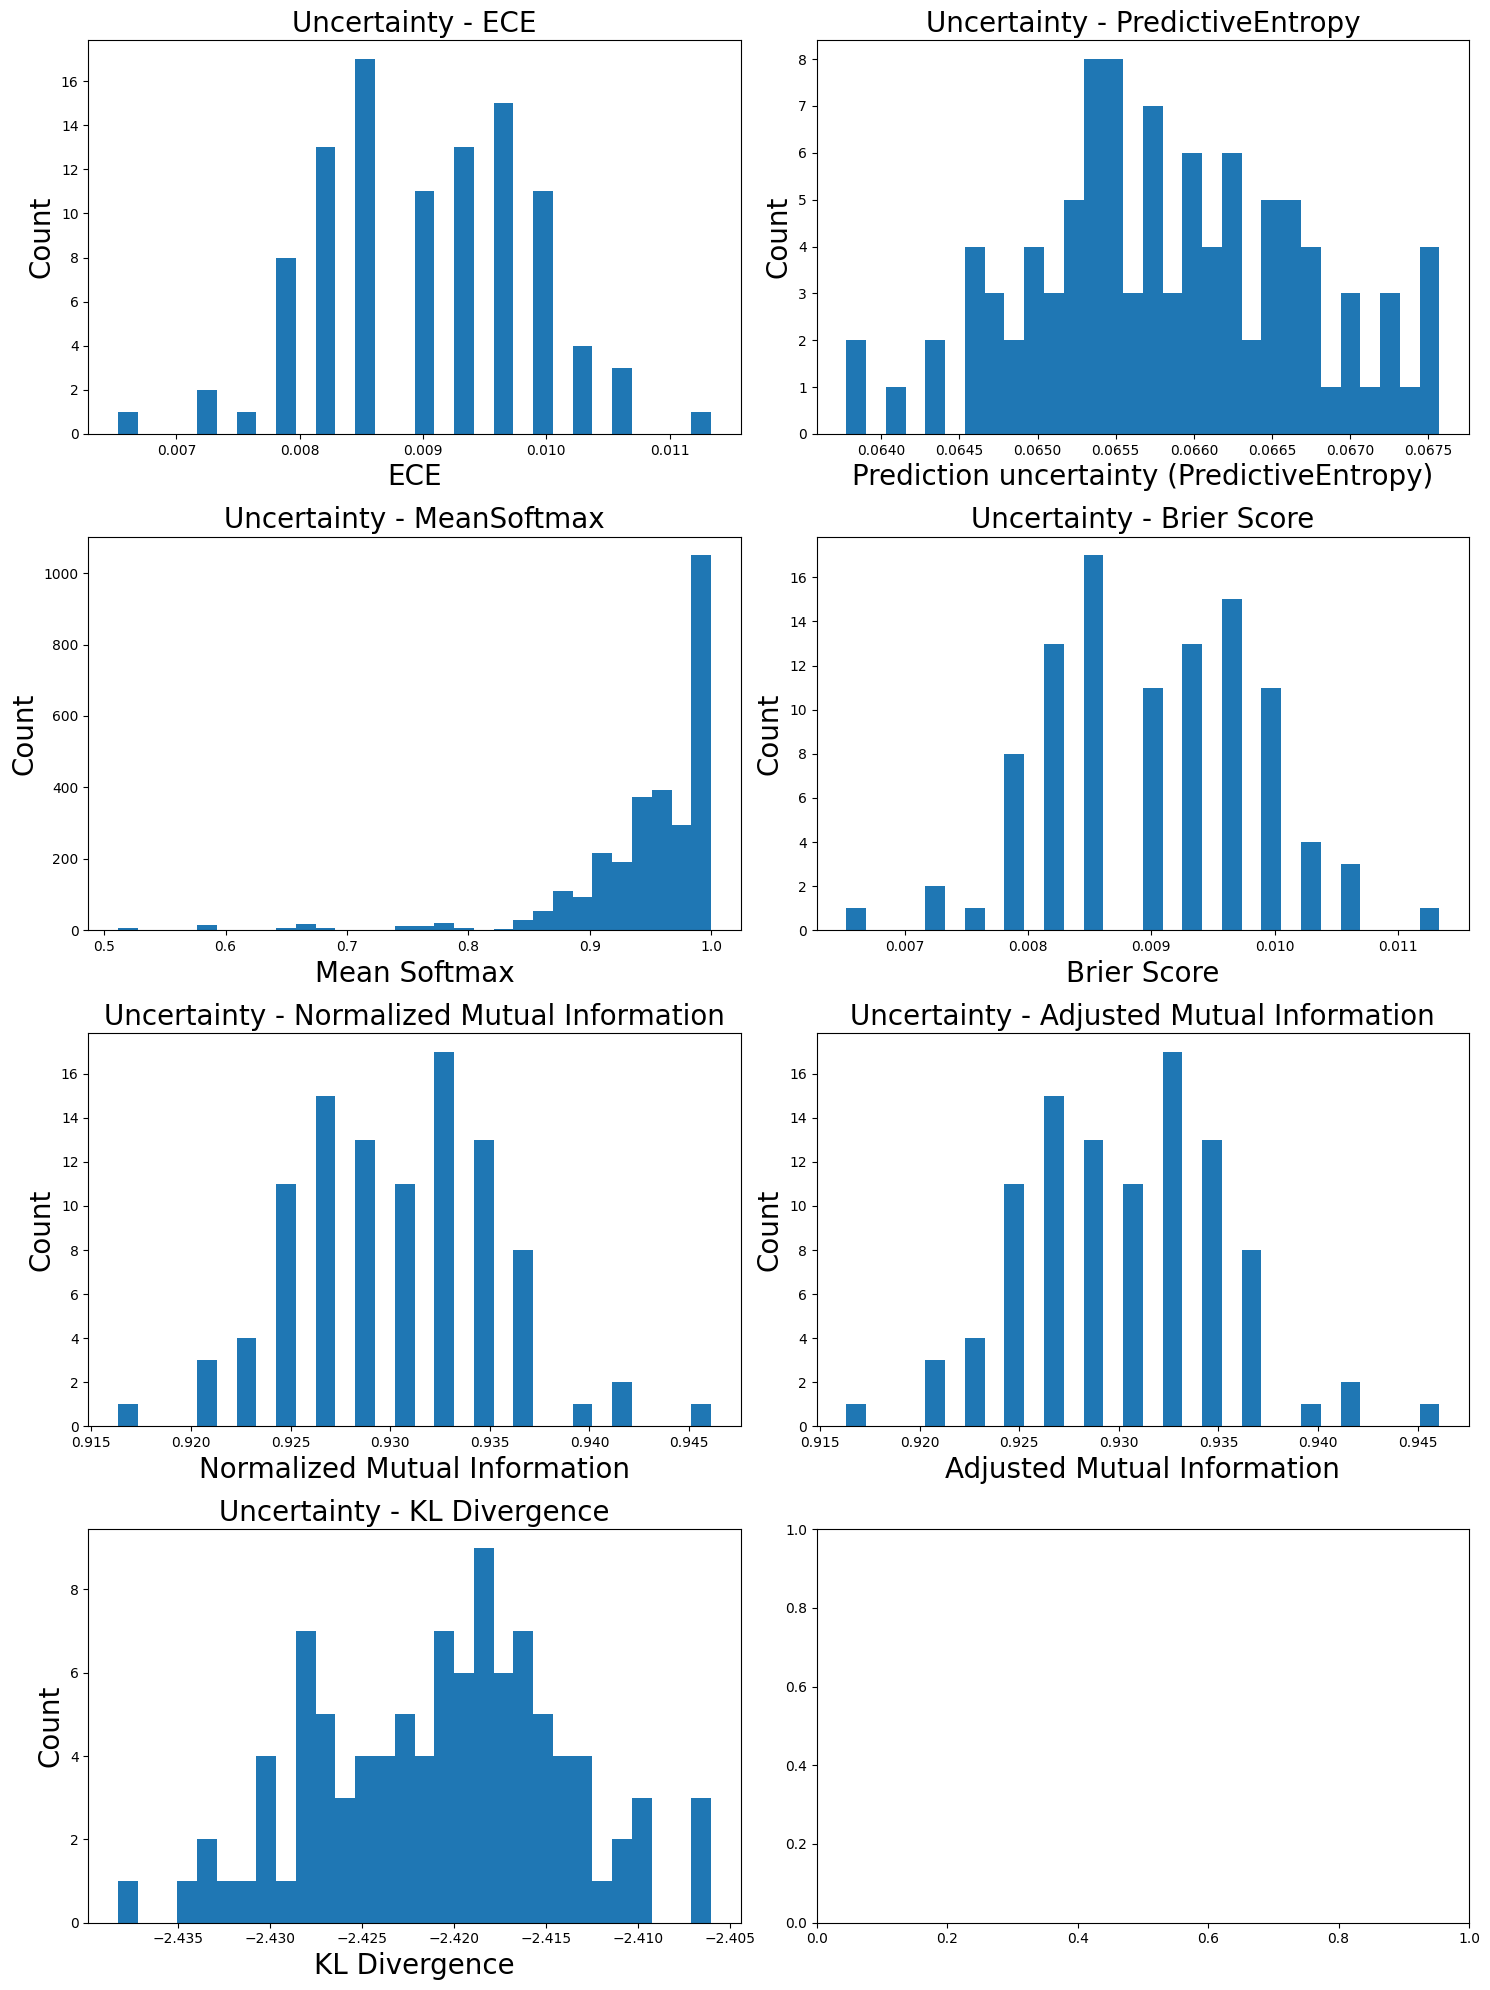

In [303]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve, CalibrationDisplay

# Calculate the predictions and prediction uncertainties using the pcs and mean_softmax quantifiers
pcs_predictions = torch.argmax(y_preds, -1)
pred_entropy_predictions = [nn.CrossEntropyLoss()(y_preds[i, :], 
                                                  test_y_ohe) 
                            for i in range(100)]
brier_score_predictions = [brier_score_loss(np.argmax(y_preds[i, :].numpy(), -1), 
                                            np.argmax(np.array(test_y_ohe), -1)) 
                           for i in range(100)]

ece_predictions = [ece(np.argmax(np.array(test_y_ohe), -1), 
                       np.argmax(y_preds[i, :].numpy(), -1)) 
                   for i in range(100)]

mi = [normalized_mutual_info_score(np.argmax(np.array(test_y_ohe), -1),
                                   np.argmax(y_preds[i, :].numpy(), -1)) 
      for i in range(100)]

ami = [adjusted_mutual_info_score(np.argmax(np.array(test_y_ohe), -1),
                                  np.argmax(y_preds[i, :].numpy(), -1)) 
       for i in range(100)]

kl = [nn.functional.kl_div(y_preds[i, :], 
                           torch.Tensor(np.array(test_y_ohe)), 
                           reduction="batchmean")
      for i in range(100)]

probs = [calibration_curve(np.argmax(np.array(test_y_ohe), -1), 
                                         np.argmax(y_preds[i, :].numpy(), -1), 
                                         n_bins=3) for i in range(100)]

m = nn.Softmax(dim=-1)
output = m(y_preds)
mean_softmax_uncertainties = np.mean(output.numpy(), 0)
mean_softmax_uncertainties = np.max(mean_softmax_uncertainties, -1)

# Create a subplot with 2 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Increase the font size for all subplots
fontsize = 20

# Plot a histogram of the prediction uncertainties from pcs in the first subplot
#pcs_predictions = np.max(pcs_predictions, -1)
axs[0, 0].hist(ece_predictions, bins=30)
axs[0, 0].set_xlabel('ECE', fontsize=fontsize)
axs[0, 0].set_ylabel('Count', fontsize=fontsize)
axs[0, 0].set_title('Uncertainty - ECE', fontsize=fontsize)

# Plot a histogram of the prediction uncertainties from pred_entropy in the second subplot
axs[0, 1].hist(pred_entropy_predictions, bins=30)
axs[0, 1].set_xlabel('Prediction uncertainty (PredictiveEntropy)', fontsize=fontsize)
axs[0, 1].set_ylabel('Count', fontsize=fontsize)
axs[0, 1].set_title('Uncertainty - PredictiveEntropy', fontsize=fontsize)

# Plot a histogram of the prediction uncertainties from mean_softmax in the third subplot
axs[1, 0].hist(mean_softmax_uncertainties, bins=30)
axs[1, 0].set_xlabel('Mean Softmax', fontsize=fontsize)
axs[1, 0].set_ylabel('Count', fontsize=fontsize)
axs[1, 0].set_title('Uncertainty - MeanSoftmax', fontsize=fontsize)

# Plot a histogram of the prediction uncertainties from mean_softmax in the third subplot
axs[1, 1].hist(ece_predictions, bins=30)
axs[1, 1].set_xlabel('Brier Score', fontsize=fontsize)
axs[1, 1].set_ylabel('Count', fontsize=fontsize)
axs[1, 1].set_title('Uncertainty - Brier Score', fontsize=fontsize)


# Plot a histogram of the prediction uncertainties from mean_softmax in the third subplot
axs[2, 0].hist(mi, bins=30)
axs[2, 0].set_xlabel('Normalized Mutual Information', fontsize=fontsize)
axs[2, 0].set_ylabel('Count', fontsize=fontsize)
axs[2, 0].set_title('Uncertainty - Normalized Mutual Information', fontsize=fontsize)


# Plot a histogram of the prediction uncertainties from mean_softmax in the third subplot
axs[2, 1].hist(ami, bins=30)
axs[2, 1].set_xlabel('Adjusted Mutual Information', fontsize=fontsize)
axs[2, 1].set_ylabel('Count', fontsize=fontsize)
axs[2, 1].set_title('Uncertainty - Adjusted Mutual Information', fontsize=fontsize)

# Plot a histogram of the prediction uncertainties from mean_softmax in the third subplot
axs[3, 0].hist(kl, bins=30)
axs[3, 0].set_xlabel('KL Divergence', fontsize=fontsize)
axs[3, 0].set_ylabel('Count', fontsize=fontsize)
axs[3, 0].set_title('Uncertainty - KL Divergence', fontsize=fontsize)

# Adjust the padding between the subplots
plt.tight_layout()

# Show the plot
plt.show()

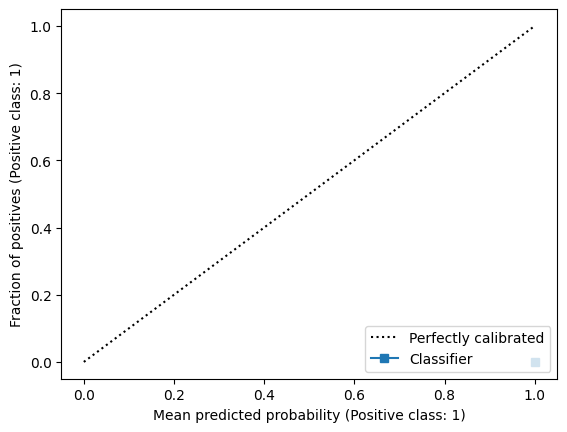

In [302]:
disp = CalibrationDisplay.from_predictions(np.array(probs)[:, 1, 0], np.array(probs)[:, 1, 1])
plt.show()